---

# Lib

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    make_scorer,
)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

import optuna

---

# Read file


In [27]:
df_train = pd.read_csv("/content/drive/MyDrive/Code/nlp-prj/train.csv", encoding="utf-8")
df_val = pd.read_csv("/content/drive/MyDrive/Code/nlp-prj/val.csv", encoding="utf-8")

In [28]:
df_train.head()

,comment,label
0,vf6 xe gia_đình ok việt_nam chủ_yếu mua xe gia...,negative
1,xe_điện ồn xe xăng sai sai,negative
2,form đẹp ác,positive
3,thể_thao đấy,positive
4,xe vinfast chạy dịch_vụ phổ_biến sạc miễn_phí ...,negative


In [29]:
df_val.head()

,comment,label
0,đại_lý dường_như đóng_cửa rào_cảm dân ta dè mu...,negative
1,base trần_truồng vòng tua_máy 48 x tiệm cận xe...,negative
2,cross chạy ngon,positive
3,khoang lái bố_cục đẹp,positive
4,đầu xe xấu,negative


---

# Labels

## Train

In [30]:
matrix_labels_train = df_train["label"]

In [31]:
matrix_labels_train.head()

,label
0,negative
1,negative
2,positive
3,positive
4,negative


In [32]:
print(f"Number of labels: {len(matrix_labels_train.unique())}")
print(f"Labels: {matrix_labels_train.unique()}")

Number of labels: 3
Labels: ['negative' 'positive' 'neutral']


## Val

In [33]:
matrix_labels_val = df_val["label"]

In [34]:
matrix_labels_val.head()

,label
0,negative
1,negative
2,positive
3,positive
4,negative


In [35]:
print(f"Number of labels: {len(matrix_labels_val.unique())}")
print(f"Labels: {matrix_labels_val.unique()}")

Number of labels: 3
Labels: ['negative' 'positive' 'neutral']


---

# Train, val split


In [36]:
# Train
X_train = df_train[["comment"]]
y_train = matrix_labels_train

# Validation
X_val = df_val[["comment"]]
y_val = matrix_labels_val

In [37]:
# Encode labels
le= LabelEncoder()
y_train = le.fit_transform(y_train).astype(np.int64)
y_val = le.transform(y_val).astype(np.int64)

---

# Vectorize


In [38]:
vec = TfidfVectorizer(
    analyzer="char",
    min_df=3,
    max_df=0.95,
    ngram_range=(3, 5),
    max_features=30000,
)

In [39]:
# Fit TF-IDF on training and transform train/test
X_train_vec = vec.fit_transform(X_train["comment"])
X_val_vec = vec.transform(X_val["comment"])

In [40]:
# To dense arrays
X_train_vec = X_train_vec.toarray().astype(np.float32)
X_val_vec = X_val_vec.toarray().astype(np.float32)

In [41]:
print(f"Train shape: {X_train_vec.shape}")
print(f"Test shape: {X_val_vec.shape}")
print(f"Vocabulary size: {len(vec.get_feature_names_out())}")

Train shape: (3592, 28463)
Test shape: (1040, 28463)
Vocabulary size: 28463


In [42]:
print("Number of classes (train): ", len(le.classes_))
print("Number of classes (val): ", len(le.classes_))

Number of classes (train):  3
Number of classes (val):  3


In [43]:
n_features = X_train_vec.shape[1]
n_classes = len(le.classes_)

---

# FNN


## Model


In [44]:
# Build model function
def build_model(input_dim, output_dim, params):
    model = Sequential()

    # First hidden layer
    model.add(Dense(
        params["hidden1"],
        activation="relu",
        input_shape=(input_dim,),
        kernel_regularizer=l2(params.get("l2_reg", 0.01))
    ))
    model.add(BatchNormalization())
    model.add(Dropout(params["dropout1"]))

    # Second hidden layer
    if params["n_layers"] >= 2:
        model.add(Dense(
            params["hidden2"],
            activation="relu",
            kernel_regularizer=l2(params.get("l2_reg", 0.01))
        ))
        model.add(BatchNormalization())
        model.add(Dropout(params["dropout2"]))

    # Third hidden layer
    if params["n_layers"] >= 3:
        model.add(Dense(
            params["hidden3"],
            activation="relu",
            kernel_regularizer=l2(params.get("l2_reg", 0.01))
        ))
        model.add(BatchNormalization())
        model.add(Dropout(params["dropout3"]))

    # Fourth hidden layer
    if params["n_layers"] >= 4:
        model.add(Dense(
            params["hidden4"],
            activation="relu",
            kernel_regularizer=l2(params.get("l2_reg", 0.01))
        ))
        model.add(BatchNormalization())
        model.add(Dropout(params["dropout4"]))

    # Single-label multiclass: softmax + sparse categorical crossentropy
    model.add(Dense(output_dim, activation="softmax"))

    model.compile(
        optimizer=Adam(learning_rate=params["lr"]),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [45]:
# Objective function for Optuna
def objective(trial):

    params = {
        "n_layers": trial.suggest_int("n_layers", 2, 4),
        "hidden1": trial.suggest_categorical("hidden1", [512, 768, 1024]),
        "hidden2": trial.suggest_categorical("hidden2", [256, 384, 512]),
        "hidden3": trial.suggest_categorical("hidden3", [128, 192, 256]),
        "hidden4": trial.suggest_categorical("hidden4", [64, 96, 128]),
        "dropout1": trial.suggest_float("dropout1", 0.3, 0.6),
        "dropout2": trial.suggest_float("dropout2", 0.3, 0.5),
        "dropout3": trial.suggest_float("dropout3", 0.2, 0.5),
        "dropout4": trial.suggest_float("dropout4", 0.2, 0.4),
        "l2_reg": trial.suggest_float("l2_reg", 1e-5, 1e-2, log=True),
        "lr": trial.suggest_float("lr", 1e-4, 5e-3, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [8, 16, 32, 64]),
    }

    model = build_model(input_dim=n_features, output_dim=n_classes, params=params)

    early_stop = EarlyStopping(
        monitor="val_loss", patience=3, restore_best_weights=True
    )

    # Use precomputed numeric vectors for training/validation
    model.fit(
        X_train_vec,
        y_train,
        validation_data=(X_val_vec, y_val),
        epochs=20,
        batch_size=params["batch_size"],
        callbacks=[early_stop],
        verbose=0,
    )

    y_val_prob = model.predict(X_val_vec)
    y_val_pred = np.argmax(y_val_prob, axis=1)

    f1 = f1_score(y_val, y_val_pred, average="macro")

    return f1

In [47]:
# Optuna study
study = optuna.create_study(direction="maximize", study_name="fnn_f1_macro")
study.optimize(objective, n_trials=10)

[I 2025-12-19 02:54:11,261] A new study created in memory with name: fnn_f1_macro


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


[I 2025-12-19 03:01:26,611] Trial 0 finished with value: 0.36649344539252793 and parameters: {'n_layers': 4, 'hidden1': 512, 'hidden2': 512, 'hidden3': 256, 'hidden4': 96, 'dropout1': 0.3241502382937475, 'dropout2': 0.4821241706185806, 'dropout3': 0.3879473057150802, 'dropout4': 0.25596975173941794, 'l2_reg': 0.00015813251483692142, 'lr': 0.000533781745195277, 'batch_size': 32}. Best is trial 0 with value: 0.36649344539252793.


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step


[I 2025-12-19 03:25:59,011] Trial 1 finished with value: 0.4971558802382541 and parameters: {'n_layers': 4, 'hidden1': 768, 'hidden2': 256, 'hidden3': 256, 'hidden4': 64, 'dropout1': 0.4776837932998661, 'dropout2': 0.36257404900635826, 'dropout3': 0.4594589488668469, 'dropout4': 0.25848016345574176, 'l2_reg': 0.0007343793003537959, 'lr': 0.002522565764707725, 'batch_size': 32}. Best is trial 1 with value: 0.4971558802382541.


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


[I 2025-12-19 03:47:50,738] Trial 2 finished with value: 0.515735206858315 and parameters: {'n_layers': 3, 'hidden1': 512, 'hidden2': 512, 'hidden3': 256, 'hidden4': 96, 'dropout1': 0.368777314236919, 'dropout2': 0.31038173544008135, 'dropout3': 0.3302337685437172, 'dropout4': 0.2378055049723059, 'l2_reg': 0.00452927219447278, 'lr': 0.0004024151250241875, 'batch_size': 32}. Best is trial 2 with value: 0.515735206858315.


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


[I 2025-12-19 04:26:50,910] Trial 3 finished with value: 0.49218907421124475 and parameters: {'n_layers': 4, 'hidden1': 1024, 'hidden2': 256, 'hidden3': 192, 'hidden4': 96, 'dropout1': 0.5827633264695922, 'dropout2': 0.3176999319099601, 'dropout3': 0.37950979188314077, 'dropout4': 0.3555967772854681, 'l2_reg': 0.009504122550447386, 'lr': 0.0010145896794941395, 'batch_size': 32}. Best is trial 2 with value: 0.515735206858315.


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


[I 2025-12-19 04:38:20,745] Trial 4 finished with value: 0.45288886707508064 and parameters: {'n_layers': 2, 'hidden1': 768, 'hidden2': 512, 'hidden3': 128, 'hidden4': 64, 'dropout1': 0.49062648499979294, 'dropout2': 0.42358132216199884, 'dropout3': 0.35457769645951853, 'dropout4': 0.38700689254498133, 'l2_reg': 2.865216803486143e-05, 'lr': 0.0002885124995045988, 'batch_size': 16}. Best is trial 2 with value: 0.515735206858315.


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step


[I 2025-12-19 05:04:09,991] Trial 5 finished with value: 0.48271100473873174 and parameters: {'n_layers': 2, 'hidden1': 1024, 'hidden2': 512, 'hidden3': 192, 'hidden4': 96, 'dropout1': 0.37811744121936847, 'dropout2': 0.42810544738662126, 'dropout3': 0.3717736992233245, 'dropout4': 0.27582353269567983, 'l2_reg': 0.005611802962187451, 'lr': 0.0028452310090007343, 'batch_size': 64}. Best is trial 2 with value: 0.515735206858315.


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


[I 2025-12-19 05:12:46,792] Trial 6 finished with value: 0.4858286166731174 and parameters: {'n_layers': 2, 'hidden1': 768, 'hidden2': 512, 'hidden3': 256, 'hidden4': 96, 'dropout1': 0.47210306447853156, 'dropout2': 0.3060050726342586, 'dropout3': 0.3259926118693667, 'dropout4': 0.34834106375335727, 'l2_reg': 0.0010952334974932024, 'lr': 0.00014190170068945334, 'batch_size': 32}. Best is trial 2 with value: 0.515735206858315.


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step


[I 2025-12-19 05:49:05,045] Trial 7 finished with value: 0.4533955495662286 and parameters: {'n_layers': 3, 'hidden1': 768, 'hidden2': 384, 'hidden3': 192, 'hidden4': 128, 'dropout1': 0.3277565009602939, 'dropout2': 0.3770822865625748, 'dropout3': 0.26373928316464845, 'dropout4': 0.37595749583527044, 'l2_reg': 0.005149848445126426, 'lr': 0.004457230085100992, 'batch_size': 16}. Best is trial 2 with value: 0.515735206858315.


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


[I 2025-12-19 06:01:41,977] Trial 8 finished with value: 0.44384901569468055 and parameters: {'n_layers': 3, 'hidden1': 512, 'hidden2': 512, 'hidden3': 128, 'hidden4': 128, 'dropout1': 0.42195603761337824, 'dropout2': 0.4758971148419375, 'dropout3': 0.21400965143656678, 'dropout4': 0.305914268395989, 'l2_reg': 6.962591838656182e-05, 'lr': 0.0011225547399060646, 'batch_size': 8}. Best is trial 2 with value: 0.515735206858315.


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


[I 2025-12-19 06:13:20,912] Trial 9 finished with value: 0.4775834210274896 and parameters: {'n_layers': 3, 'hidden1': 768, 'hidden2': 256, 'hidden3': 256, 'hidden4': 128, 'dropout1': 0.43818472006884834, 'dropout2': 0.47665407145978955, 'dropout3': 0.2883639620708875, 'dropout4': 0.39980755065986506, 'l2_reg': 0.002258012547351685, 'lr': 0.00020680472659099881, 'batch_size': 16}. Best is trial 2 with value: 0.515735206858315.


In [48]:
print("Best f1:", study.best_value)
print("Best trial:", study.best_trial.number)

Best f1: 0.515735206858315
Best trial: 2


In [49]:
best_params = study.best_params

print("Best params:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

Best params:
  n_layers: 3
  hidden1: 512
  hidden2: 512
  hidden3: 256
  hidden4: 96
  dropout1: 0.368777314236919
  dropout2: 0.31038173544008135
  dropout3: 0.3302337685437172
  dropout4: 0.2378055049723059
  l2_reg: 0.00452927219447278
  lr: 0.0004024151250241875
  batch_size: 32


In [50]:
# Build final model with best hyperparameters
model = build_model(n_features, n_classes, best_params)

In [51]:
# Fit final model
model.fit(
    X_train_vec, y_train, epochs=20, batch_size=best_params["batch_size"], verbose=1
)

Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 53s 429ms/step - accuracy: 0.4134 - loss: 7.5177
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 44s 386ms/step - accuracy: 0.7026 - loss: 6.1244
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 44s 383ms/step - accuracy: 0.8372 - loss: 5.6800
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 82s 383ms/step - accuracy: 0.9023 - loss: 5.2046
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 82s 384ms/step - accuracy: 0.9293 - loss: 4.7738
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 82s 384ms/step - accuracy: 0.9256 - loss: 4.4159
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 82s 389ms/step - accuracy: 0.9502 - loss: 4.0069
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 81s 383ms/step - accuracy: 0.9414 - loss: 3.7002
Epoch 9/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 82s 384ms/step - accuracy: 0.9556 - loss: 3.3880
Epoch 10/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 43s 380ms/step - accuracy: 0.9392 - loss: 3.2063
Epoch 11/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 43s 379ms/step - accuracy: 0.9511 - loss: 2.9787
Epoch 12/20
113/113

## Eval


In [116]:
# Predict
y_prob = model.predict(X_val_vec)
y_pred = np.argmax(y_prob, axis=1)

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step


In [117]:
# Compute metrics
metrics = {
    "accuracy_score": accuracy_score(y_val, y_pred),
    "precision_macro": precision_score(y_val, y_pred, average="macro", zero_division=0),
    "recall_macro": recall_score(y_val, y_pred, average="macro", zero_division=0),
    "f1_macro": f1_score(y_val, y_pred, average="macro", zero_division=0),
}

matrix_metrics = pd.DataFrame.from_dict(metrics, orient="index", columns=["score"])

In [118]:
matrix_metrics.round(4)

,score
accuracy_score,0.6606
precision_macro,0.5144
recall_macro,0.4989
f1_macro,0.4890


In [119]:
print(classification_report(y_val, y_pred, target_names=le.classes_, zero_division=0))

              precision    recall  f1-score   support

    negative       0.64      0.69      0.66       410
     neutral       0.21      0.05      0.08       105
    positive       0.70      0.76      0.73       525

    accuracy                           0.66      1040
   macro avg       0.51      0.50      0.49      1040
weighted avg       0.62      0.66      0.64      1040



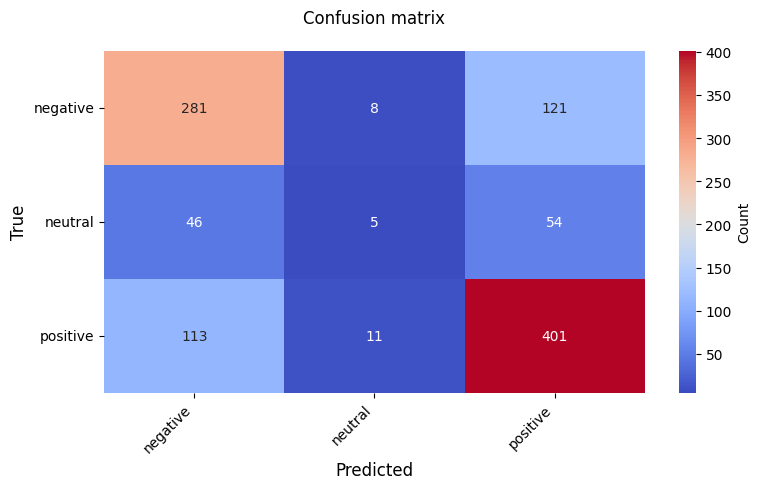

In [120]:
# Confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='coolwarm',
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion matrix', pad=20)
plt.ylabel('True', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Test


In [121]:
df_test = pd.read_csv("/content/drive/MyDrive/Code/nlp-prj/test.csv")
df_test_predict = df_test.copy()
df_test_predict.shape

(500, 7)

In [122]:
# Try prediction on some samples
samples = df_test["comment"].tolist()
samples_vec = vec.transform(samples).toarray()

# Use the trained final model for predictions
probs = model.predict(samples_vec)
preds = np.argmax(probs, axis=1)

for i, (text, pred_idx) in enumerate(zip(samples, preds)):
    label_name = le.inverse_transform([pred_idx])[0]
    confidence = probs[i][pred_idx]
    df_test_predict.at[i, "predicted_label"] = label_name
    df_test_predict.at[i, "confidence"] = confidence

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


In [123]:
df_test_predict.head()

,brand,model,version,year,segment,comment,label,predicted_label,confidence
0,geely,coolray,flagship,2025,suv,"Xe Geely giờ uy tín hơn, bán chạy ở nhiều nước.",positive,positive,0.952962
1,nissan,kicks,e-powers,2025,suv,Ngáo giá nên ế có thế thôi,negative,negative,0.999989
2,huyndai,accent,NaN,2024,sedan,"nhìn cứng cáp, hiện đại quá",positive,positive,0.695551
3,toyota,yaris cross,máy xăng,2024,suv,"Yari Cross trang bị an toàn hơn, bền bỉ hơn, b...",positive,positive,0.939853
4,skoda,slavia,style,2025,sedan,Riêng quả gạt mưa + gương chống chói tự động +...,positive,positive,0.849113


In [125]:
df_test_predict[["segment", "label", "predicted_label"]].groupby(["segment", "label", "predicted_label"]).value_counts()

segment  label     predicted_label
sedan    negative  negative            37
                   neutral              1
                   positive            20
         neutral   negative            12
                   positive             7
         positive  negative            28
                   positive            72
suv      negative  negative           103
                   neutral              2
                   positive            34
         neutral   negative            20
                   neutral              1
                   positive            10
         positive  negative            55
                   positive            98
Name: count, dtype: int64